# Temperature Profile Classification - 2 Class system - r1
GMM classification of Southern Ocean Argo float temperature profile data. This notebook uses a previously created model, PCA and sample data.<br><br>
### Dask import

In [1]:
#Dask setup cell
target_version='0.19.0'
!pip install xarray=={target_version} --upgrade #--upgrade

import logging
import subprocess
from dask.distributed import Client
from dask_gateway import Gateway
from distributed import WorkerPlugin

import dask
dask.config.set({"array.slicing.split_large_chunks": True})

class PipPlugin(WorkerPlugin):
    """ Install packages on a worker as it starts up.
 
    Parameters
    ----------
    packages : List[str] - A list of packages to install with pip on startup. """
    def __init__(self, packages):
        self.packages = packages
 
    def setup(self, worker):
        logger = logging.getLogger("distributed.worker")
        subprocess.call(['python', '-m', 'pip', 'install', '--upgrade'] + self.packages)
        logger.info("Installed %s", self.packages)
        
def check():
    import xarray
    return xarray.__version__

gateway = Gateway()

In [2]:
#Dask server launcher cell
if False:
    cluster = gateway.new_cluster(worker_memory=8)
    cluster.scale(20)
    client = Client(cluster)
    plugin = PipPlugin([f'xarray=={target_version}'])
    client.register_worker_plugin(plugin)

    print(client.run(check), "\n")
    client

In [3]:
if False:
    options = gateway.cluster_options()
    options.worker_cores = 4
    options.worker_memory = 8
    cluster = gateway.new_cluster(cluster_options=options)
    client = Client(cluster)
    plugin = PipPlugin([f'xarray=={target_version}'])
    client.register_worker_plugin(plugin)

    print(client.run(check), "\n")
    client

In [4]:
if False:
    client.close()
    cluster.close()

<br>

### Choices for data

In [5]:
#Experiment data for analysis
dataVariableId = 'thetao'
dataExperimentId = 'historical'
dataSourceId = 'UKESM1-0-LL'
dataInstitutionId = 'MOHC'
approvedIds = ["r1i1p1f2", "r2i1p1f2", "r3i1p1f2"] #insert start of approved member_ids

#File imports
maskName = "OceanMaskVolcello"
modelName = "GMM_UK_2Class_R1"

#Data definitions
startDate = '1980-01'
endDate = '2009-12'
timeRange = slice(startDate, endDate)
levSel = slice(0, 2000) #Selected levels to be investigated
maxLat = -30 #Selected latitude to be investigated
runIdSel = 0

#Custom GMM variables
pcaNControl = 3 #set to int value to select, otherwise pcaThreshold is used to automatically assign value

<br>

### Libaries and Modules
Importing the necessary libaries and modules for the notebook.

In [6]:
#Import cell
import calendar
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import dask.dataframe as dd
import fsspec
import matplotlib.dates as mdates
import matplotlib as mpl ###
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as ticker
import xarray as xr
import zarr

from dask import config
from dask import delayed
from joblib import dump, load
from matplotlib.pyplot import cm
from sklearn import mixture
from sklearn.decomposition import PCA
from sklearn import preprocessing
from scipy import signal

config.set(**{'array.slicing.split_large_chunks': True})
print("Imports complete")

Imports complete


<br>

### Importing data sets
Importing the data for the models.

<b>Import sample data set and corresponding time/geo data</b>

In [7]:
importName = modelName + "_Meta_Full"
sampleMetaDFL = pd.read_csv(importName)
sampleMetaDFL = sampleMetaDFL.drop(columns=["Unnamed: 0"])
sampleMetaDFL["time"] = pd.to_datetime(sampleMetaDFL["time"])
print("Labeled sample meta data loaded from "+ importName +" and stored in sampleMetaDFL. "+ str(len(sampleMetaDFL)) +" samples loaded.")
sampleMetaDFL.head()

Labeled sample meta data loaded from GMM_UK_2Class_R1_Meta_Full and stored in sampleMetaDFL. 7989840 samples loaded.


lat   lon       time  labelSorted  max posterior prob  \
0 -66.111520  73.5 1980-01-01            0                 1.0   
1 -65.703316  73.5 1980-01-01            0                 1.0   
2 -65.288570  73.5 1980-01-01            0                 1.0   
3 -64.867195  73.5 1980-01-01            0                 1.0   
4 -64.439100  73.5 1980-01-01            0                 1.0   

   classUncertainty  
0      7.016077e-09  
1      1.517286e-09  
2      3.287965e-10  
3      6.635226e-11  
4      1.154099e-11

In [8]:
#Meta data date processing cell
globalStartDate = sampleMetaDFL["time"][0]
globalDateInc = sampleMetaDFL["time"].unique()[1] - globalStartDate
globalEndDateIn = sampleMetaDFL["time"].iloc[-1]
globalEndDateOut = globalEndDateIn + globalDateInc

globalStartDateStr = str(globalStartDate)[:7]
globalEndDateInStr = str(globalEndDateIn)[:7]
globalEndDateOutStr = str(globalEndDateOut)[:7]
print("Sample meta data dates manipulated and stored in globalStartDate etc.")

Sample meta data dates manipulated and stored in globalStartDate etc.


<br>
<b>Loading ocean Masks</b>

In [9]:
#Ocean mask import cell
maskFile = xr.open_dataset(maskName)
oceanMask = maskFile.to_array()
maskFile = xr.open_dataset("OceanMaskUKESM1")
oceanMask2 = maskFile.to_array()
print("Mask Loaded and stored in oceanMask and oceanMask2 (volcello and UKESM).")

Mask Loaded and stored in oceanMask and oceanMask2 (volcello and UKESM).


<br>
<b>Unpacking ocean masks</b>

In [10]:
#Mask unpacking cell
geoRange = oceanMask #copying mask
geoRange = geoRange.rename({"variable":"cleanMe"}) #Dimension removal
geoRange = geoRange.sel(cleanMe = geoRange.cleanMe.values[0]) #Dimension removal
geoRange = geoRange.reset_coords("cleanMe", drop=True) #Dimension removal
geoRangeS = geoRange.stack(ij =("i", "j")) #Stacking
geoRangeFilt = geoRangeS.dropna("ij")
print("Ocean mask unpacked into geoRangeFilt.")

geoRange2 = oceanMask2 #copying mask
geoRange2S = geoRange2.stack(ij =("i", "j")) #Stacking
geoRangeFilt2 = geoRange2S.dropna("ij")
print("UKESM Ocean mask unpacked into geoRangeFilt2.")

Ocean mask unpacked into geoRangeFilt.
UKESM Ocean mask unpacked into geoRangeFilt2.


<br>
<b>Date Calculations</b>

In [11]:
#Date calculation cell
startDateNp = np.datetime64(startDate, 'M')
endDateNp = np.datetime64(endDate, 'M')
timeDiff = endDateNp - startDateNp
timeDiff = timeDiff.astype(int) + 1
print("Calculated date range.")

Calculated date range.


<br>

### Calculation functions
<b>Functions:</b><br>
<ul>
<li>pickRand - Takes in data frame and returns sampled data frame with a randomly selected number of rows from the input data frame, controled by the second input variable to the function.
<li>storeMeta - Returns a np array containing the latitude and longitude data for an input xarray and associated ij.
<li>loadModel - loadeds and returns GMM model named in input.
<li>saveModel - saves input GMM model to provided name, if no name provided default is GMMGenerated.
</ul>

In [12]:
#Calculation functions cell
def butter_lowpass(data,cut,order=4,sample_freq=1) :
    nyq = 0.5*sample_freq
    pass_freq =1./cut/nyq
    sos=signal.butter(order, pass_freq, 'low', output='sos')
    filt=signal.sosfiltfilt(sos,data)
    return filt

def pickRand(dataArray, sampleFactor):
    '''Returns a sample of the input array, size of sampled array is based on sampleFactor. For factor > 1 that many points are chosen, for factor < 1 that % is taken of the array'''
    arrLen = len(dataArray)
    if sampleFactor > 1:
        sampleSize = int(sampleFactor)
    elif sampleFactor > 0:
        sampleSize = int(sampleFactor*arrLen)
    else:
        return 1
    
    filtArr = np.zeros(arrLen, dtype=bool) # empty mask
    sampleId = np.random.choice(arrLen, sampleSize, False) # np array of randomly generated non repeating numbers
    for i in sampleId:
        filtArr[i] = True # populating mask
    return dataArray[filtArr] # applies mask


def pickRandMask(maskLen, maskQuantity, sampleFactor):
    '''Returns a linear mask for the input dimensions, size of mask is based on sampleFactor. For factor > 1 that many points are chosen, for factor < 1 that % is taken of the array'''
    if sampleFactor > 1:
        sampleSize = int(sampleFactor)
    elif sampleFactor > 0:
        sampleSize = int(sampleFactor*maskLen)
    else:
        return 1
    
    globalArr = np.empty(shape=(0), dtype=bool)
    for i in range(maskQuantity):
        filtArr = np.zeros(maskLen, dtype=bool) # empty mask
        sampleId = np.random.choice(maskLen, sampleSize, False) # np array of randomly generated non repeating numbers
        for j in sampleId:
            filtArr[j] = True # populating mask
        globalArr = np.append(globalArr, filtArr)
    return globalArr


def storeMeta(dataArray):
    '''Returns a np array containing the latitude and longitude data for the input xarray and the associated ij index'''
    storeLen = len(dataArray["lat"]) # assumes each lat has a corresponding lon
    storage = np.empty(shape=(0,storeLen))
    storage = np.append(storage, [dataArray["lat"].values], axis = 0)
    storage = np.append(storage, [dataArray["lon"].values], axis = 0)
    #storage = np.append(storage, [dataArray["time"].values], axis = 0)
    #storage = np.append(storage, [dataArray["ij"].values], axis = 0)
    return storage


def loadModel(modelName:str):
    '''Loades the input GMM model named in the functions input. Returns loaded model.'''
    means = np.load(modelName + '_means.npy')
    covar = np.load(modelName + '_covariances.npy')
    GMModel = mixture.GaussianMixture(n_components = len(means), covariance_type='full')
    GMModel.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(covar))
    GMModel.weights_ = np.load(modelName + '_weights.npy')
    GMModel.means_ = means
    GMModel.covariances_ = covar
    return GMModel


def saveModel(GMModel, modelName = "GMMGenerated"):
    '''Saves the input GMM model's weights, means and covariances. Assigns input name if provided to model.'''
    GMModel_name = str(modelName)
    np.save(modelName + '_weights', GMModel.weights_, allow_pickle=False)
    np.save(modelName + '_means', GMModel.means_, allow_pickle=False)
    np.save(modelName + '_covariances', GMModel.covariances_, allow_pickle=False)
    return 0

print("Calculation functions defined.")

Calculation functions defined.


<br>

### Plotting functions
<b>Functions:</b>
<ul>
<li> locationPlotGroup - plots location and classification of data points for an input numpy array.
<li> locationPlotGroupDF - plots location and classification of data points for an input data frame.
<li> locationPlotGroupDFMonthly - plots location and classification of data points for an input data frame in monthly subplots.
<li> locationPlotTime - plots locations of an input data array on a map with a colour scale for time.
<li> locationPlotUncertaintyDF - plots uncertainty in classification on a location plot.
</ul>

In [13]:
#Plotting functions Cell
#sampleDepthAxis = dfESMLatLevT["lev"]
decadeColours = ["green", "yellow", "red"]
timeList = sampleMetaDFL["time"].unique()

def locationPlotGroup(metaDataArray, size, plotNo):
    '''Plots locations of numpy arrays with group colour scheme'''
    plt.figure(plotNo, figsize=size)
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.coastlines()
    ax.gridlines()
    im = ax.scatter(metaDataArray[1], metaDataArray[0], transform=ccrs.PlateCarree(), c =  metaDataArray[3], cmap='RdBu_r')
    cb = plt.colorbar(im)
    plt.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
    plt.title("Grouped Sample Locations ("+str(len(metaDataArray[0]))+")")


def locationPlotGroupDFTime(dataFrame, title, size, plotNo):
    '''Plots locations of data frame points with group colour scheme'''
    plt.figure(plotNo, figsize=size)
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.coastlines()
    ax.gridlines()
    im = ax.scatter(dataFrame["lon"], dataFrame["lat"], transform=ccrs.PlateCarree(), c =  mdates.date2num(dataFrame["time"]), cmap='brg')
    cb = plt.colorbar(im)
    loc = mdates.AutoDateLocator()
    cb.ax.yaxis.set_major_locator(loc)
    cb.ax.yaxis.set_major_formatter(mdates.ConciseDateFormatter(loc))
    plt.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
    plt.title(str(title))
    
    
def locationPlotGroupDFLab(dataFrame, title, size, plotNo):
    '''Plots locations of data frame points with group colour scheme'''
    plt.figure(plotNo, figsize=size)
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.coastlines()
    ax.gridlines()
    im = ax.scatter(dataFrame["lon"], dataFrame["lat"], transform=ccrs.PlateCarree(), c =  dataFrame["labelSorted"], cmap='RdBu_r')
    cb = plt.colorbar(im)
    plt.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
    plt.title(str(title))


def locationPlotGroupDFMonthly(dataFrame, title, plotNo):
    '''Plots locations of dataframe points by monthly subplot with group colour scheme'''
    fig = plt.figure(plotNo, figsize=(30,42))
    plt.title(str(title))
    for i in range(1, 13):
        #timeData = dataFrame.where(dataFrame["time"].dt.month==i) #normal dt info
        timeData = dataFrame.where(dataFrame["time"] ==i) #groupby dt info
        ax = plt.subplot(4, 3, i, projection=ccrs.SouthPolarStereo())
        ax.add_feature(cfeature.OCEAN)
        ax.add_feature(cfeature.COASTLINE)
        ax.coastlines()
        ax.gridlines()
        im = ax.scatter(timeData["lon"], timeData["lat"], transform=ccrs.PlateCarree(), c =  timeData["labelSorted"], cmap='RdBu_r')
        plt.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
        plt.title(calendar.month_abbr[i]) 
    plt.subplots_adjust(wspace=0, hspace=0.05)
    cb_ax = fig.add_axes([0.27, 0.1, 0.5, 0.02])
    cbar = fig.colorbar(im, cax=cb_ax, orientation="horizontal")


def locationPlotTime(dataArray, size, plotNo):
    '''Plots locations of numpy arrays with date colour scheme'''
    plt.figure(plotNo, figsize=size)
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.coastlines()
    ax.gridlines()
    im = ax.scatter(dataArray[1], dataArray[0], transform=ccrs.PlateCarree(), c= mdates.date2num(dataArray[2]), cmap='brg')
    cb = plt.colorbar(im)
    loc = mdates.AutoDateLocator()
    cb.ax.yaxis.set_major_locator(loc)
    cb.ax.yaxis.set_major_formatter(mdates.ConciseDateFormatter(loc))
    plt.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
    plt.title("Sample Locations ("+str(len(dataArray[0]))+")")


def locationPlotUncertaintyDF(dataFrame, title, size, plotNo):
    '''Plots input data array classification uncertainties'''
    plt.figure(plotNo, figsize=size)
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.coastlines()
    ax.gridlines()
    im = ax.scatter(dataFrame["lon"], dataFrame["lat"], transform=ccrs.PlateCarree(), c =  dataFrame["classUncertainty"], cmap='Blues', vmin=0, vmax=1)
    cb = plt.colorbar(im)
    plt.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
    plt.title(str(title))


def locationPlotUncertaintyDFMonthly(dataFrame, title, plotNo):
    '''Plots locations of dataframe points by monthly subplot with group colour scheme'''
    fig = plt.figure(plotNo, figsize=(30,42))
    plt.title(str(title))
    for i in range(1, 13):
        #timeData = dataFrame.where(dataFrame["time"].dt.month==i) #normal dt info
        timeData = dataFrame.where(dataFrame["time"] ==i) #groupby dt info
        ax = plt.subplot(4, 3, i, projection=ccrs.SouthPolarStereo())
        ax.add_feature(cfeature.OCEAN)
        ax.add_feature(cfeature.COASTLINE)
        ax.coastlines()
        ax.gridlines()
        im = ax.scatter(timeData["lon"], timeData["lat"], transform=ccrs.PlateCarree(), c =  timeData["classUncertainty"], cmap='Blues', vmin=0, vmax=1)
        #cb = plt.colorbar(im, fraction=0.046, pad=0.04)
        plt.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
        plt.title(calendar.month_abbr[i]) 
    plt.subplots_adjust(wspace=0, hspace=0.05)
    cb_ax = fig.add_axes([0.27, 0.1, 0.5, 0.02])
    cbar = fig.colorbar(im, cax=cb_ax, orientation="horizontal")


def locationPlotXr(dataArray, size, plotNo):
    '''Plots locations of numpy arrays with date colour scheme'''
    plt.figure(plotNo, figsize=size)
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.coastlines()
    ax.gridlines()
    im = ax.scatter(dataArray["lon"], dataArray["lat"], transform=ccrs.PlateCarree())
    plt.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
    plt.title("Sample Locations ("+str(len(dataArray["lat"]))+")")        

    
def locationUncertaintyMean(decadeMeanList, decadeStdList, uncertaintyThreshold, figSize, plotNo):
    '''Plots mean latitude for classification uncertainty with +- 1 std'''
    plt.figure(plotNo, figsize=figSize)
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.coastlines()
    ax.gridlines()
    for i in range(len(decades)):
        ax.plot(decadeMeanList[i].index, decadeMeanList[i]["lat"], transform=ccrs.PlateCarree(), color=decadeColours[i], label = decades[i])
        ax.plot(decadeMeanList[i].index, decadeMeanList[i]["lat"] + decadeStdList[i]["lat"], transform=ccrs.PlateCarree(), color=decadeColours[i], ls = "--", lw = 0.75)
        ax.plot(decadeMeanList[i].index, decadeMeanList[i]["lat"] - decadeStdList[i]["lat"], transform=ccrs.PlateCarree(), color=decadeColours[i], ls = "--", lw = 0.75)
        
    ax.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
    plt.title("Classification Uncertainty above "+str(uncertaintyThreshold)+" Mean Latitude")
    plt.legend()


def timeSingleLatMean(meanLatArr, lineStyle , arrThreshold, arrSmoothFact, plotNo):
    plt.figure(plotNo, figsize=(20,10))
    plt.plot(timeList, meanLatArr, lw=1, ls=lineStyle ,label="Thresh_"+str(arrThreshold)+"_smooth"+str(arrSmoothFact))
    plt.xlabel("Date")
    plt.ylabel("Singular Mean Latitude")
    plt.title("Classification Uncertainty Mean Latitude over time")
    plt.legend()
    #plt.gca().invert_yaxis()
    
    
print("Plotting functions defined.")

Plotting functions defined.


<br>

### Plotting Ocean Mask

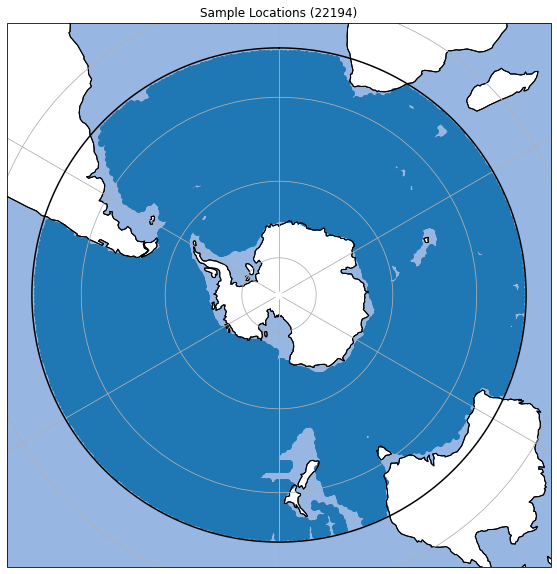

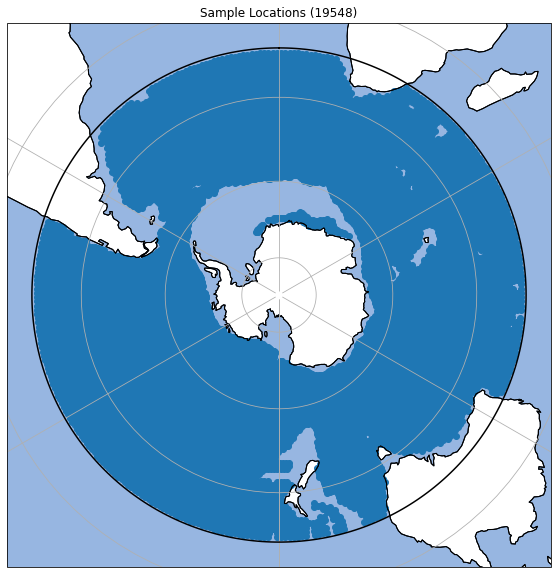

In [14]:
#Mask plotting cell
locationPlotXr(geoRangeFilt, (10,10), 1) #OceanMaskVolcello
locationPlotXr(geoRangeFilt2, (10,10), 2) #OceanMaskUKESM1
plt.show()

<br>

### Anomalies

In [15]:
#Initial anomalous data point df creation cell
labelAnomDF = sampleMetaDFL[np.logical_or(np.logical_and(sampleMetaDFL["lat"]<-60, sampleMetaDFL["labelSorted"]==1), np.logical_and(sampleMetaDFL["lat"]>-45, sampleMetaDFL["labelSorted"]==0))]
print("Class 0 above -45 and Class 1 below -60 lat. Stored in labelAnomDF. "+str(len(labelAnomDF))+" anomalous points detected.")

Class 0 above -45 and Class 1 below -60 lat. Stored in labelAnomDF. 3964 anomalous points detected.


In [16]:
#High confidence anomalous data point df creation cell
labelAnomConDF = labelAnomDF[labelAnomDF["classUncertainty"]<0.25]
print("High Classification Confidence DF of labelAnomDF (<0.25). "+str(len(labelAnomConDF))+" anomalous points detected.")

High Classification Confidence DF of labelAnomDF (<0.25). 243 anomalous points detected.


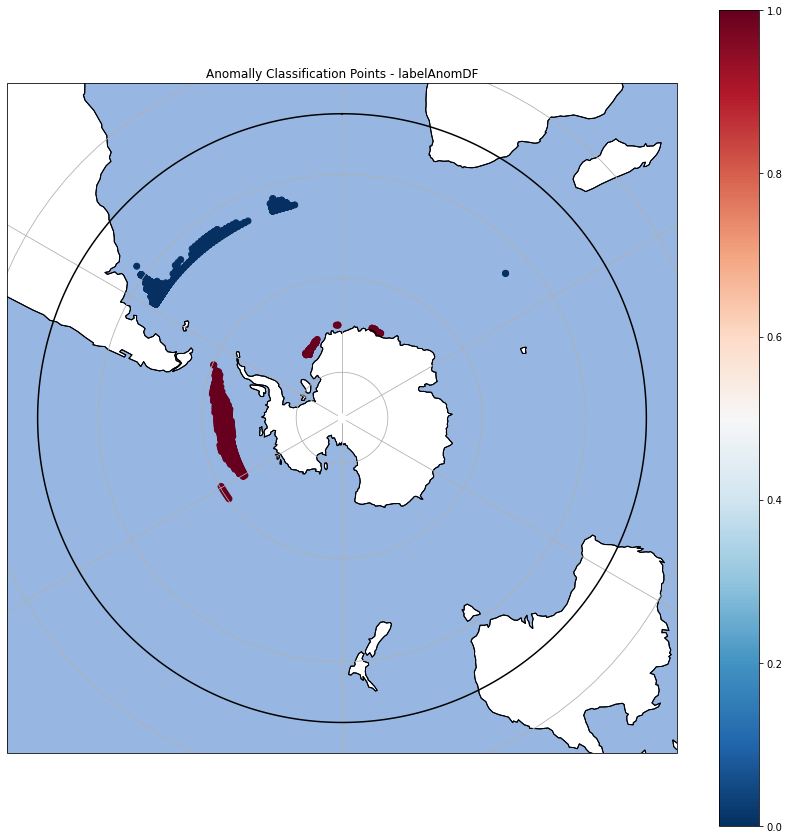

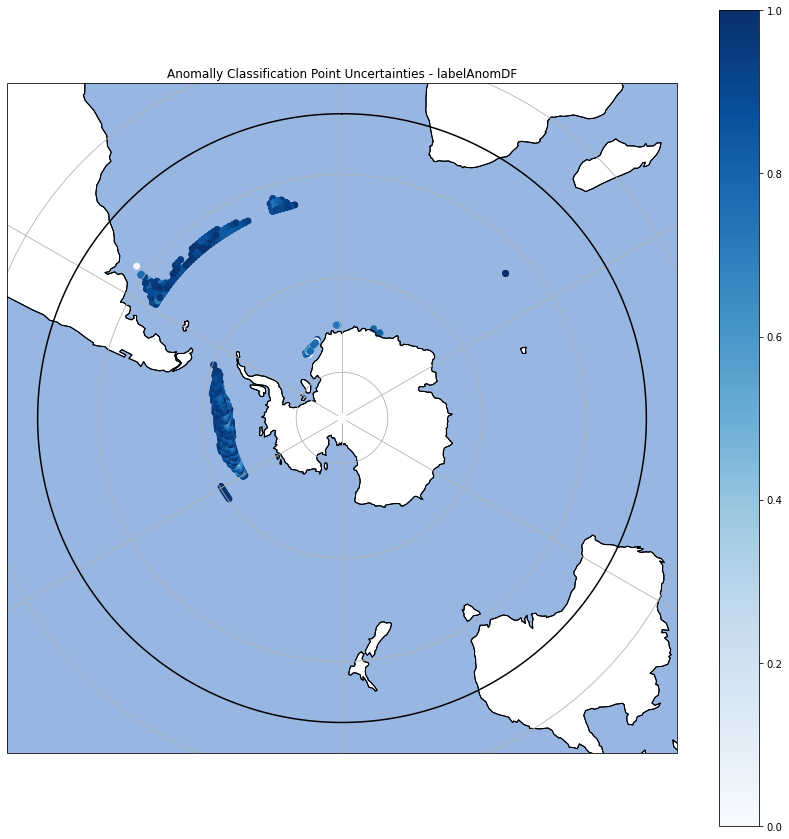

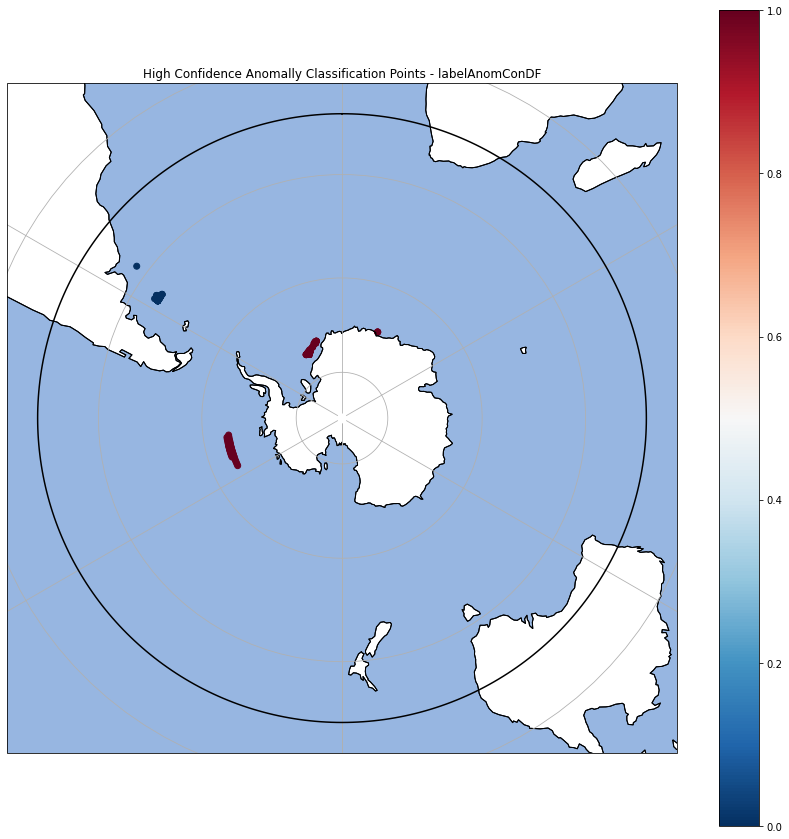

In [17]:
locationPlotGroupDFLab(labelAnomDF, "Anomally Classification Points - labelAnomDF", (15,15), 1)
locationPlotUncertaintyDF(labelAnomDF, "Anomally Classification Point Uncertainties - labelAnomDF", (15,15), 2)
locationPlotGroupDFLab(labelAnomConDF, "High Confidence Anomally Classification Points - labelAnomConDF", (15,15), 3)
plt.show()

<br>
<b>Antarctic Anomalous Classifications</b>

349 anomalous samples found.


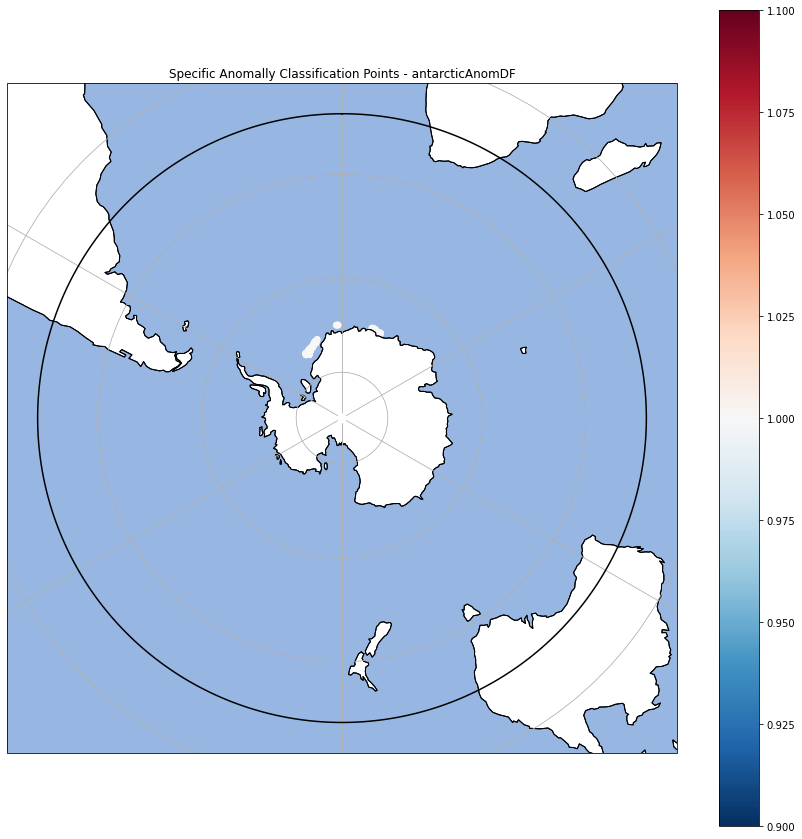

In [18]:
antarcticAnomDF = sampleMetaDFL[np.logical_and(np.logical_and(sampleMetaDFL["labelSorted"]==1, sampleMetaDFL["lat"]<-60), np.logical_and(sampleMetaDFL["lon"]>-30, sampleMetaDFL["lon"]<30))]
locationPlotGroupDFLab(antarcticAnomDF, "Specific Anomally Classification Points - antarcticAnomDF", (15,15), 1)
print(str(len(antarcticAnomDF))+" anomalous samples found.")
plt.show()

<br>

### Data Readjustment

In [19]:
preAdLen = len(sampleMetaDFL)
if True:
    sampleMetaDFL = pd.concat([sampleMetaDFL, antarcticAnomDF, antarcticAnomDF]).drop_duplicates(keep=False)
    print("Removing antarcticAnomDF.\n")
postAdLen = len(sampleMetaDFL)
lenDiff = preAdLen - postAdLen
print("SampleMetaDFL adjusted from "+str(preAdLen)+" to "+str(postAdLen)+". "+str(lenDiff)+" samples dropped.")

Removing antarcticAnomDF.

SampleMetaDFL adjusted from 7989840 to 7989491. 349 samples dropped.


In [20]:
print("Last data point in set (expected 2009-12):")
sampleMetaDFL.iloc[-1]

Last data point in set (expected 2009-12):


lat                            -30.455408
lon                             72.500000
time                  2009-12-01 00:00:00
labelSorted                             1
max posterior prob               1.000000
classUncertainty                 0.000000
Name: 7989839, dtype: object

In [21]:
antarcticAnomDF = sampleMetaDFL[np.logical_and(np.logical_and(sampleMetaDFL["labelSorted"]==1, sampleMetaDFL["lat"]<-60), np.logical_and(sampleMetaDFL["lon"]>-30, sampleMetaDFL["lon"]<30))]
antarcticLen = len(antarcticAnomDF)
if antarcticLen:
    locationPlotGroupDFLab(antarcticAnomDF, "Specific Anomally Classification Points - antarcticAnomDF", (15,15), 1)
print(str(antarcticLen)+" anomalous samples found.")
plt.show()

0 anomalous samples found.


<br>

### Average location information

In [22]:
#Average classification per location cell
averageGeoG = sampleMetaDFL.groupby(["lat", "lon"])
averageGeo = averageGeoG.mean(["lat", "lon"])
averageGeo = averageGeo.reset_index()
print("Average location information calculated and stored in averageGeo.")

Average location information calculated and stored in averageGeo.


In [23]:
#Average classification per location and month cell
averageMonthGeoG = sampleMetaDFL.groupby([sampleMetaDFL.time.dt.month, "lat", "lon"])
averageMonthGeo = averageMonthGeoG.mean(["lat", "lon"])
averageMonthGeo = averageMonthGeo.reset_index()
print("Average monthly location information calculated and stored in averageMonthGeo.")

Average monthly location information calculated and stored in averageMonthGeo.


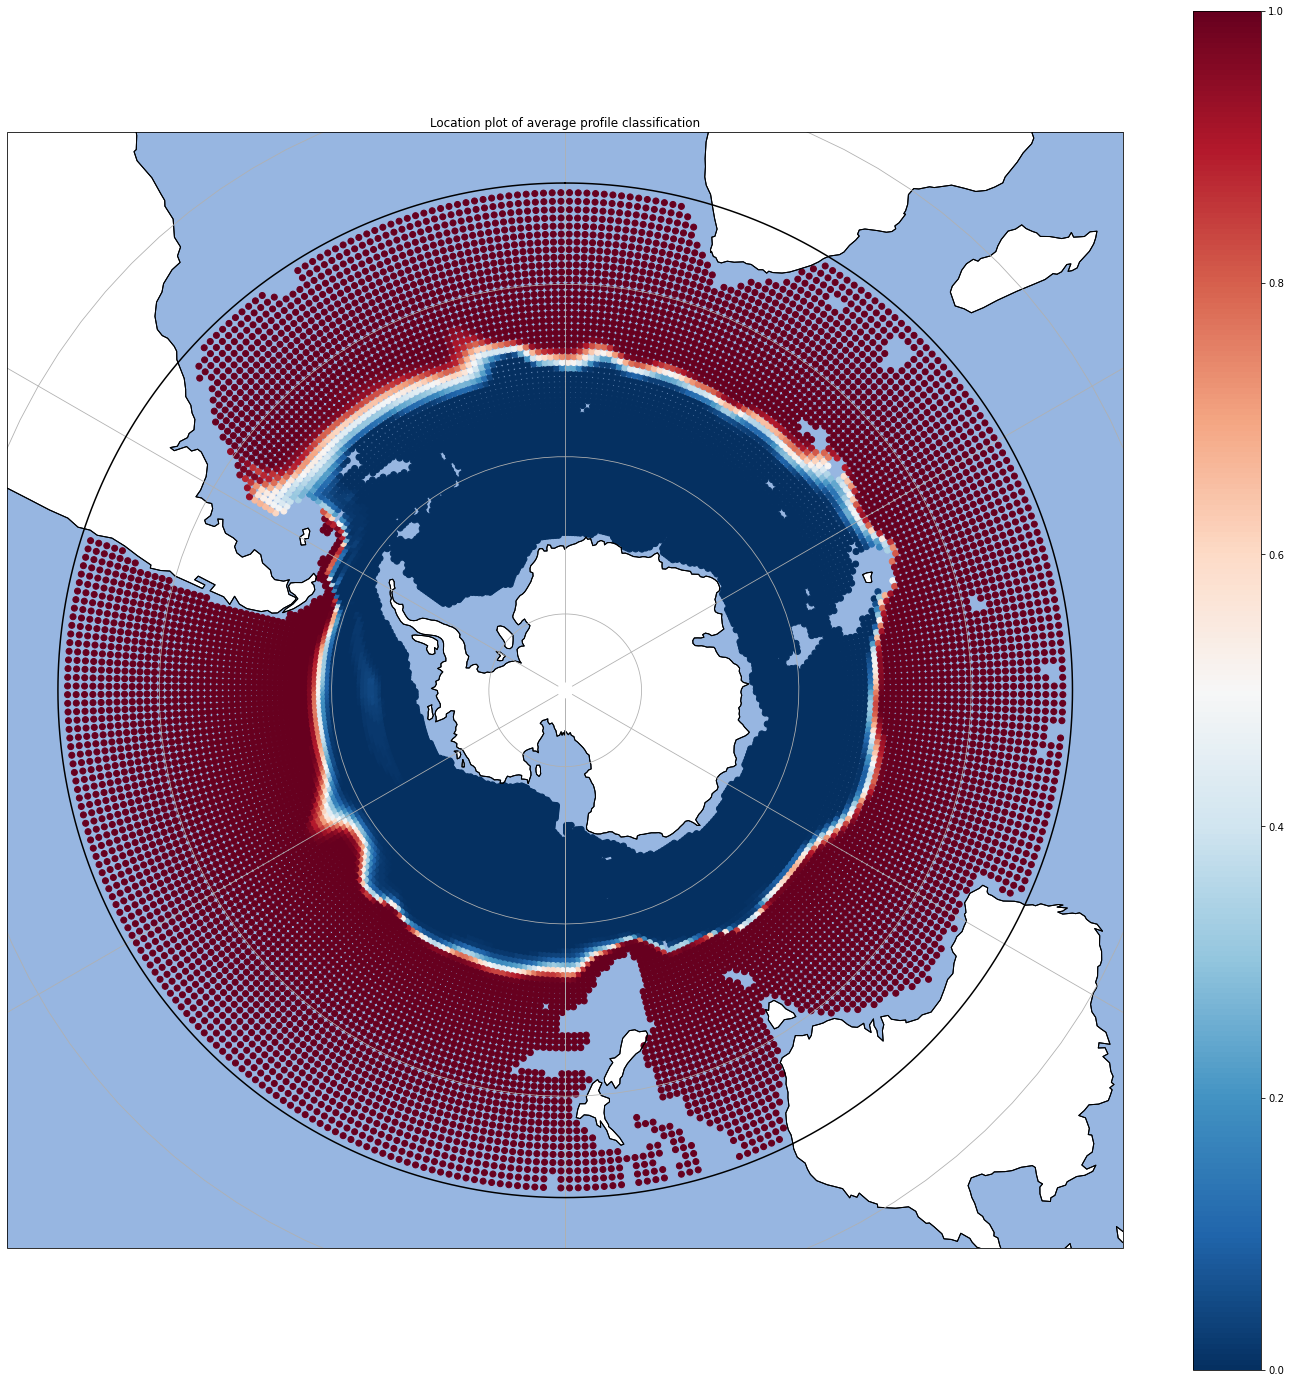

In [24]:
#Average classification location plot cell
locationPlotGroupDFLab(averageGeo, "Location plot of average profile classification", (25,25), 1)
plt.show()

Average Classifications, grouped by month.


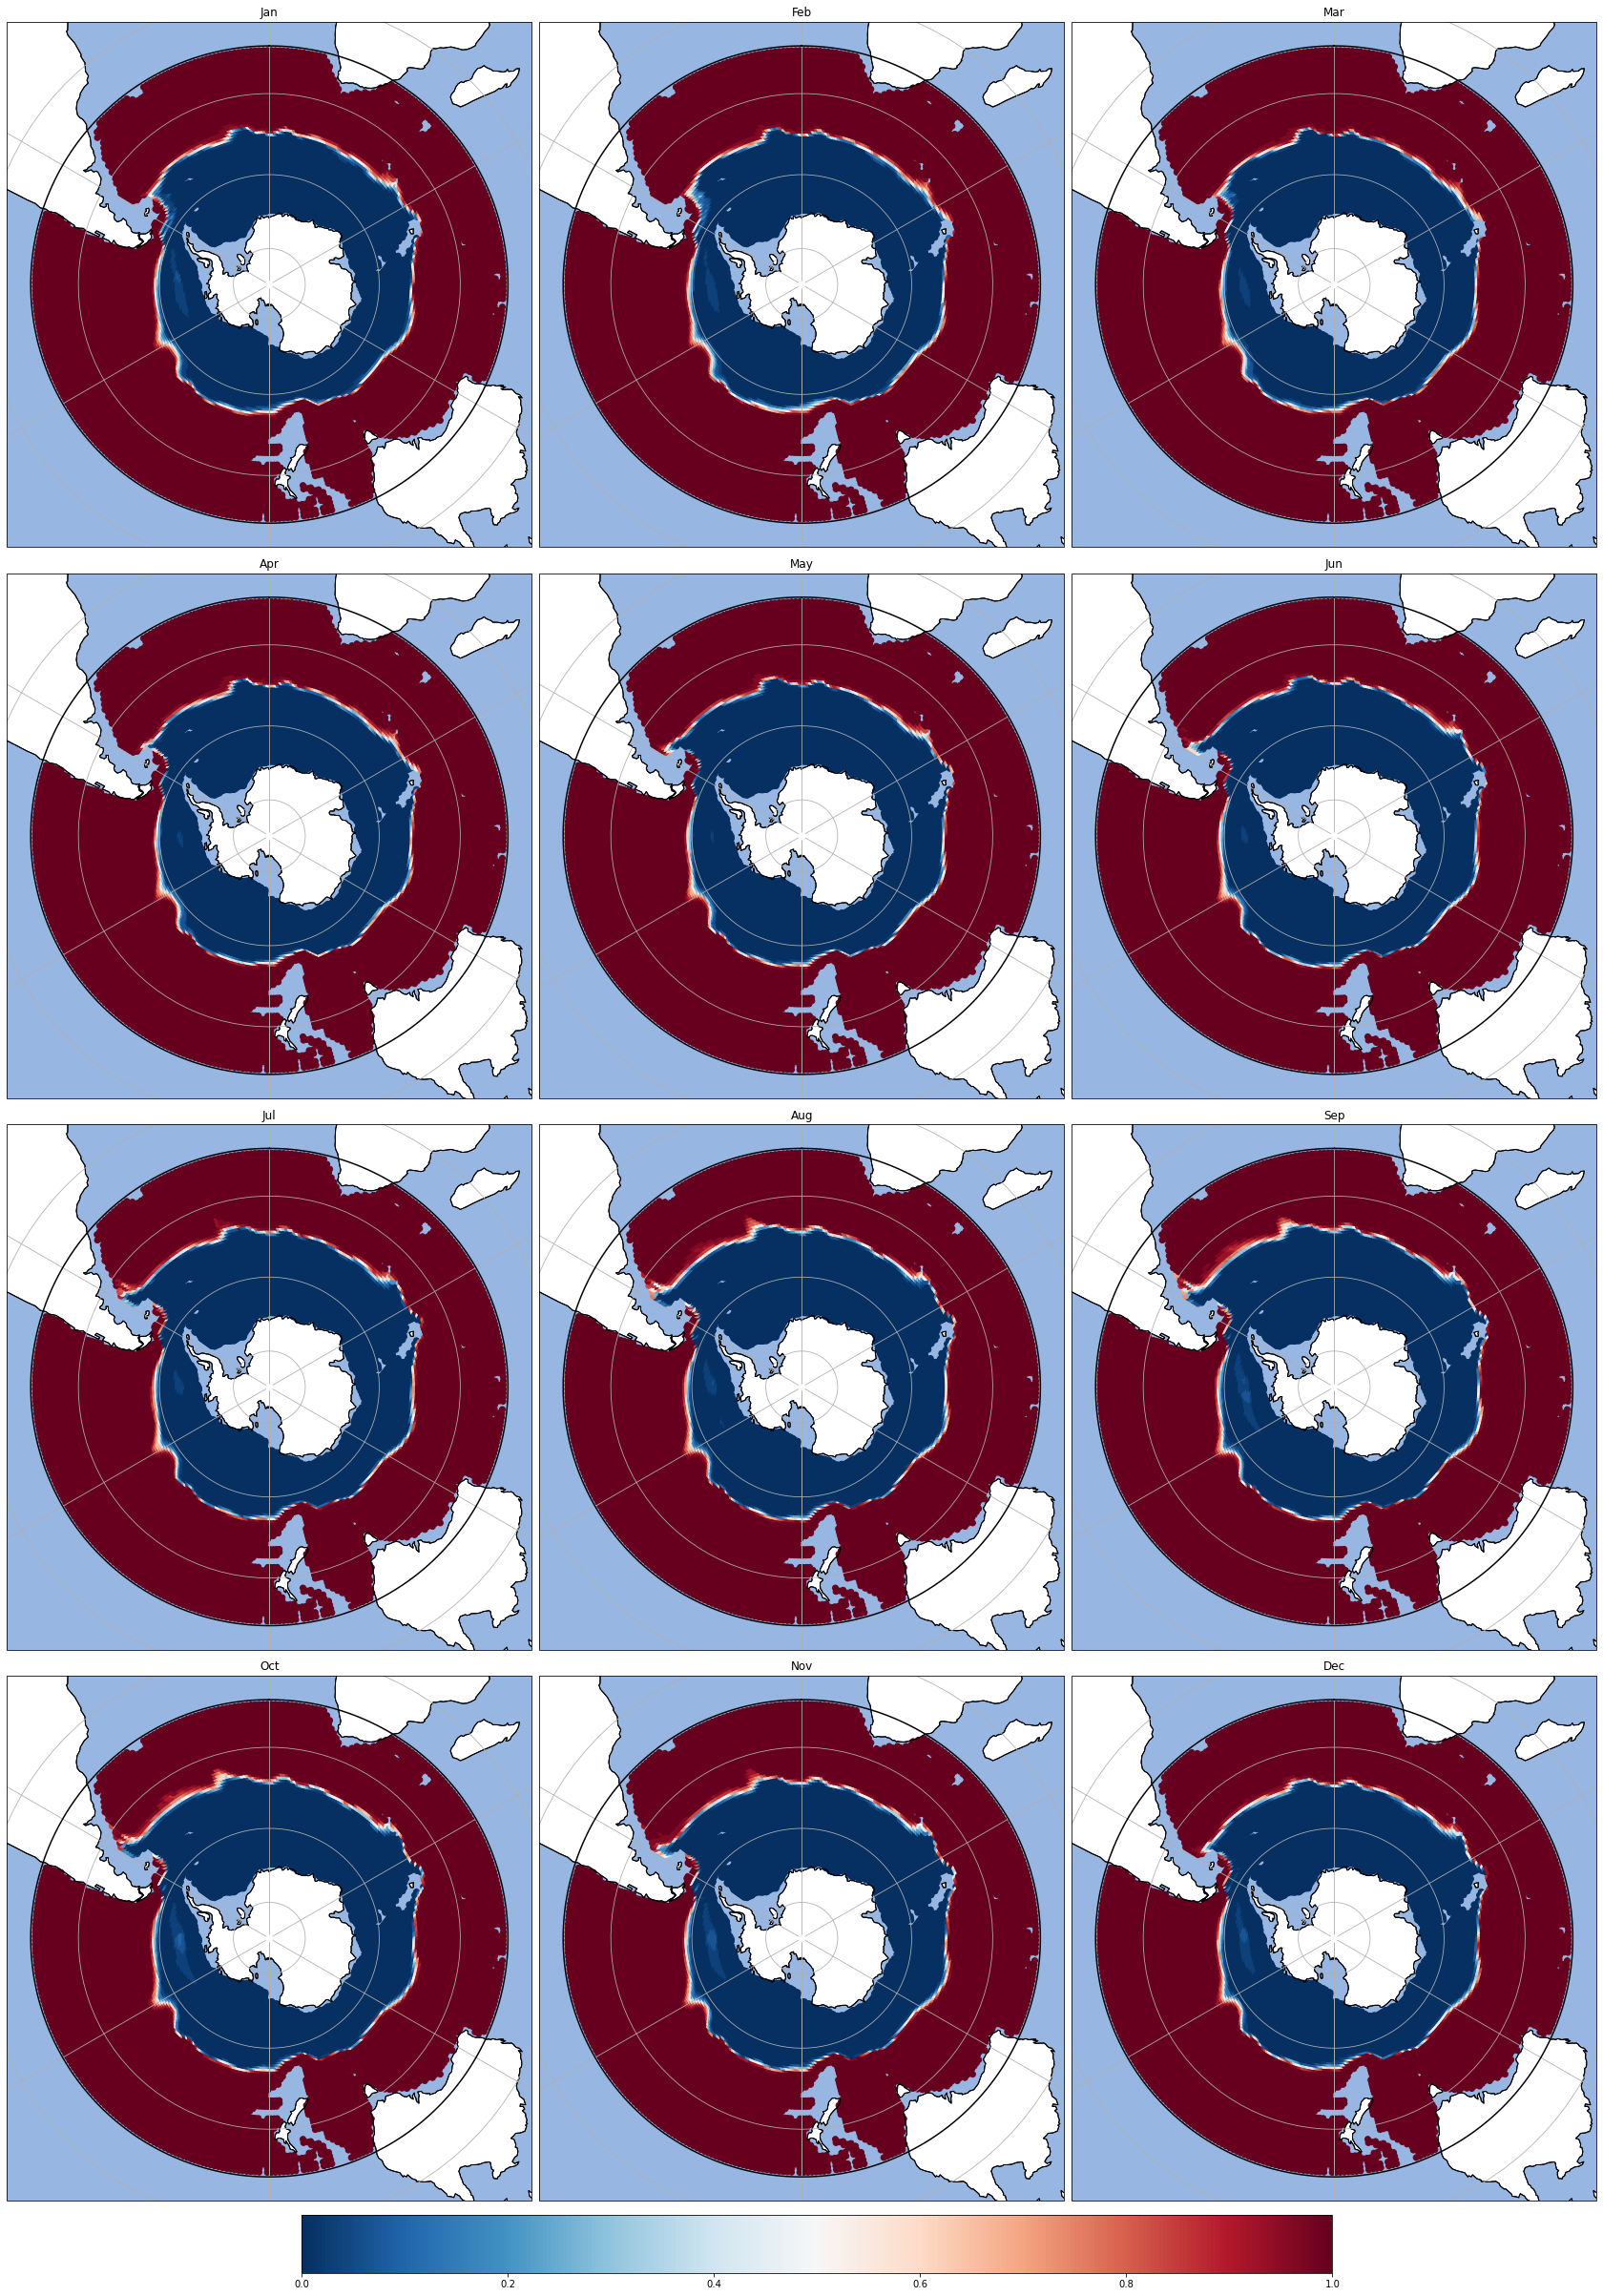

In [25]:
locationPlotGroupDFMonthly(averageMonthGeo, "Monthly summaries for training data set", 1)
print("Average Classifications, grouped by month.")
plt.show()

Average Uncertainty in classifications, grouped by month.


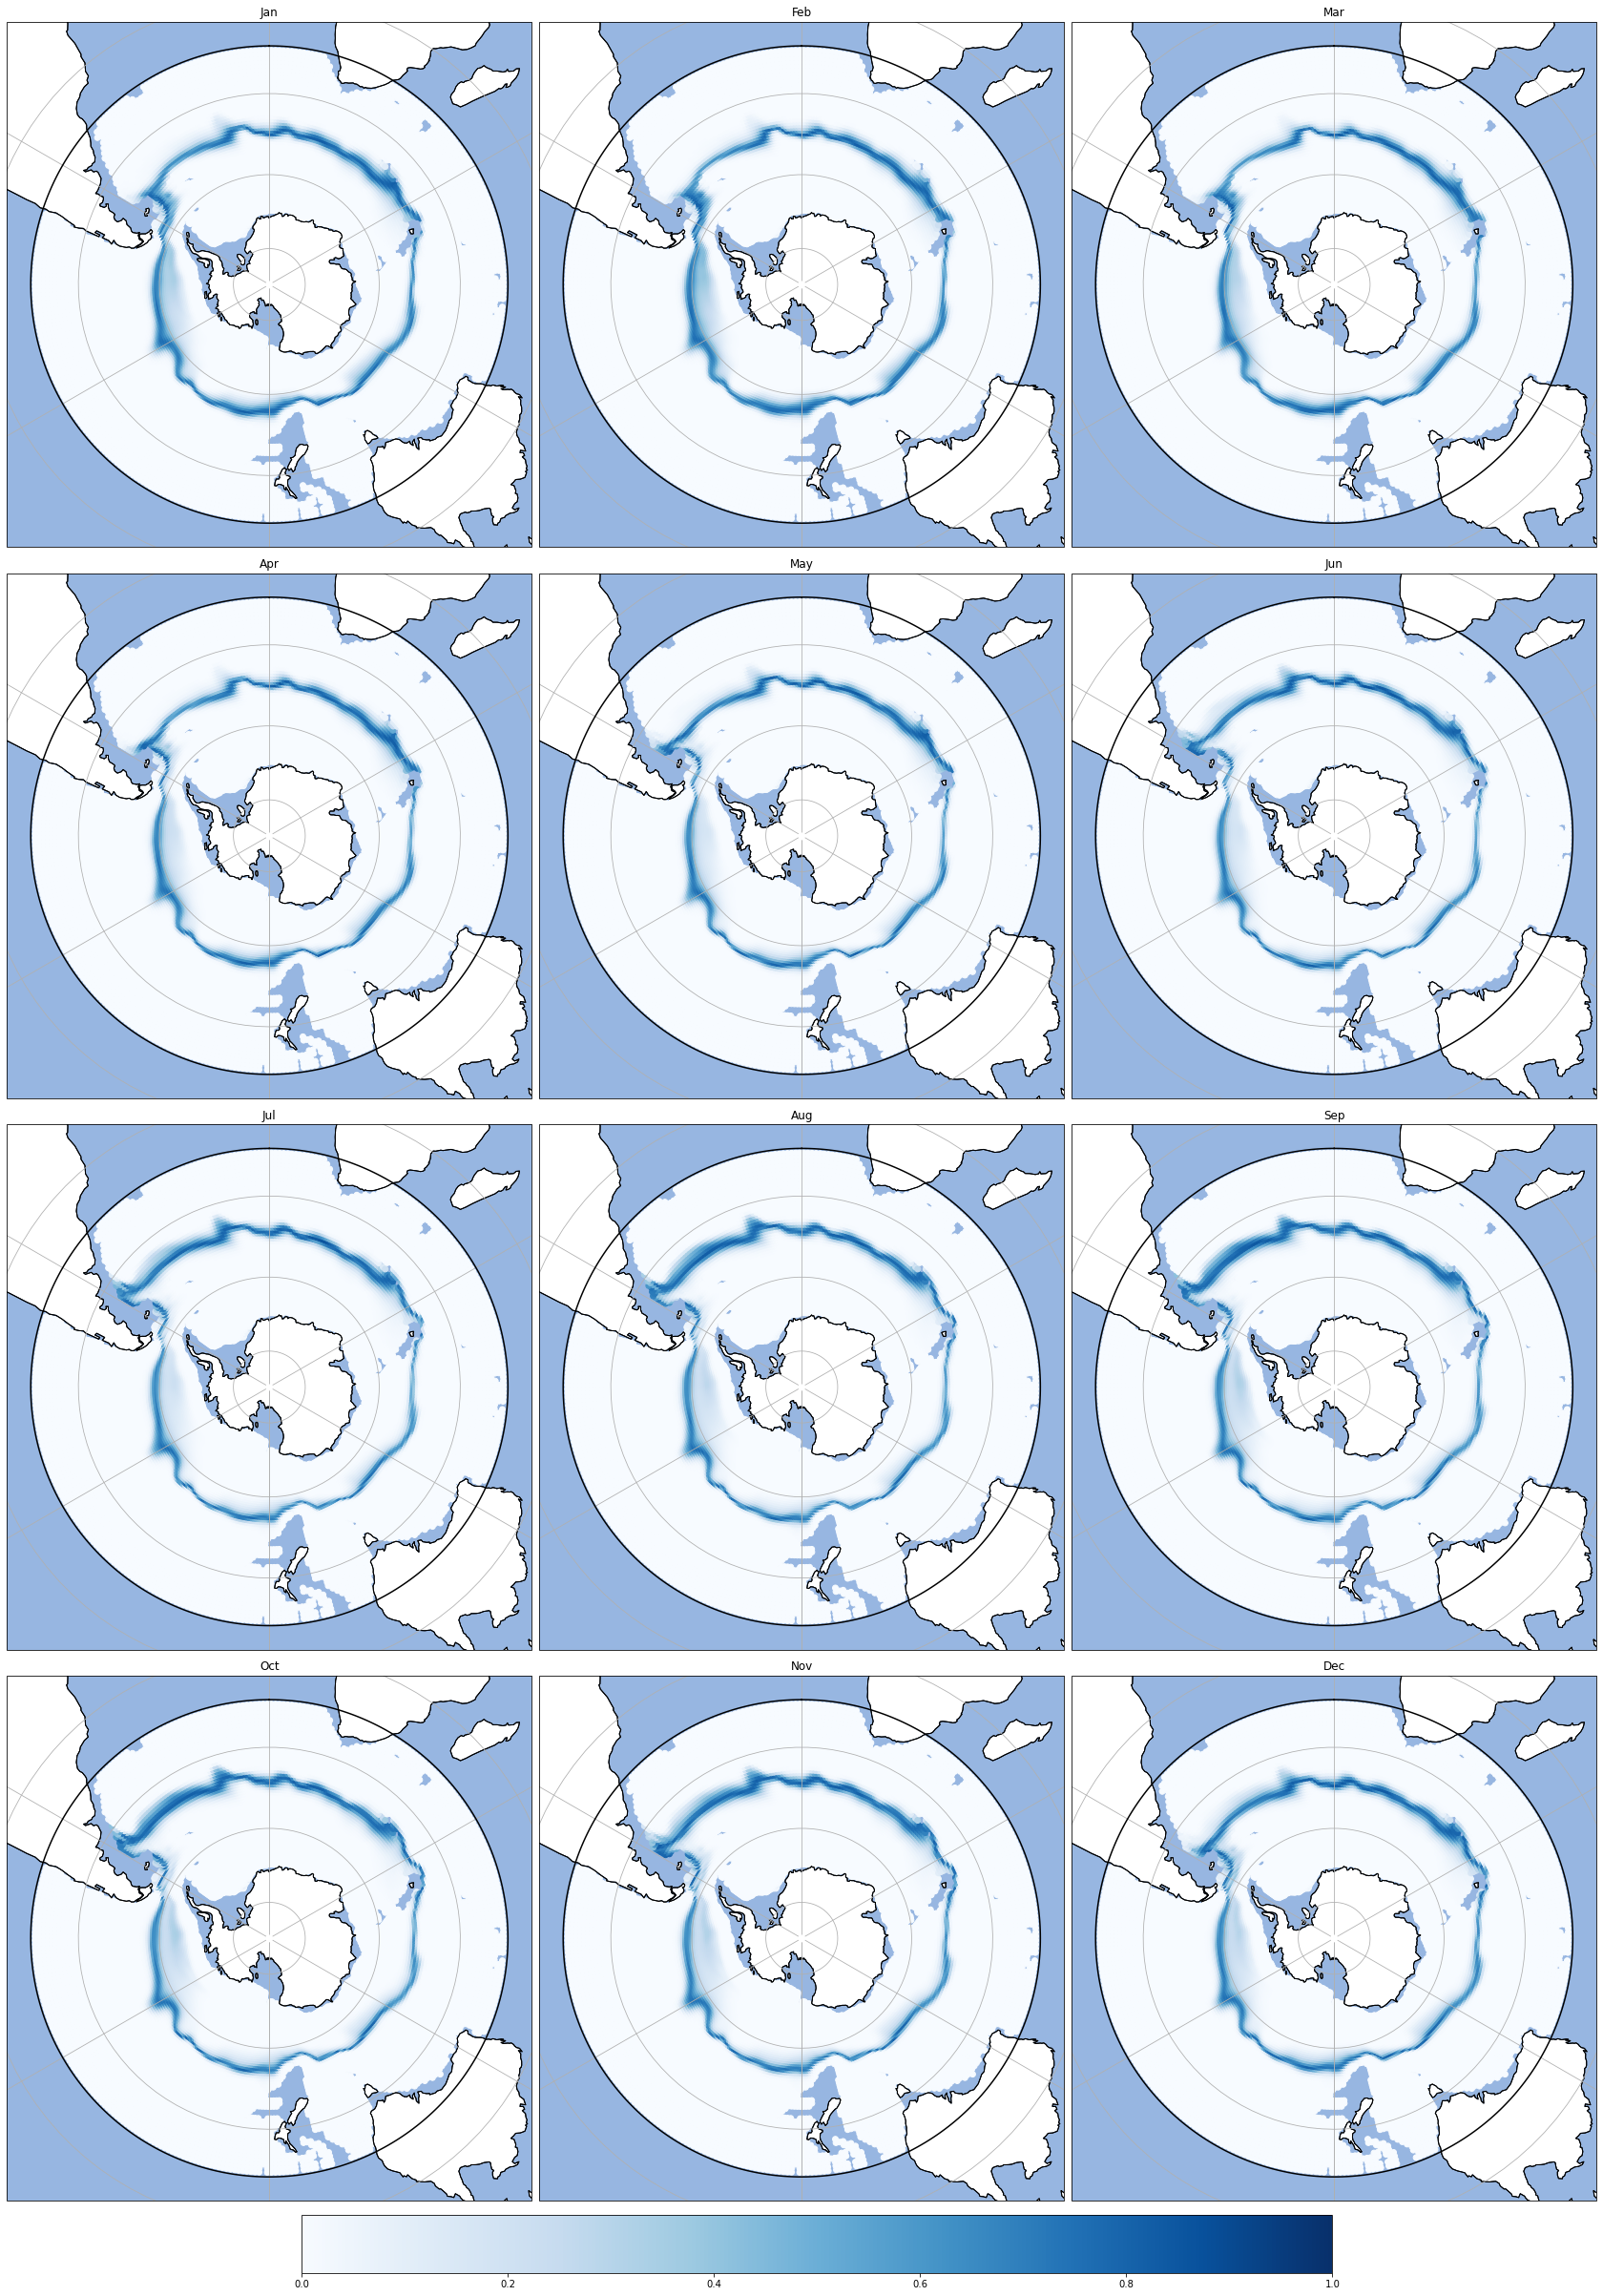

In [26]:
locationPlotUncertaintyDFMonthly(averageMonthGeo, "Monthly uncertainty", 1)
print("Average Uncertainty in classifications, grouped by month.")
plt.show()

<br>

### Single Month Properities

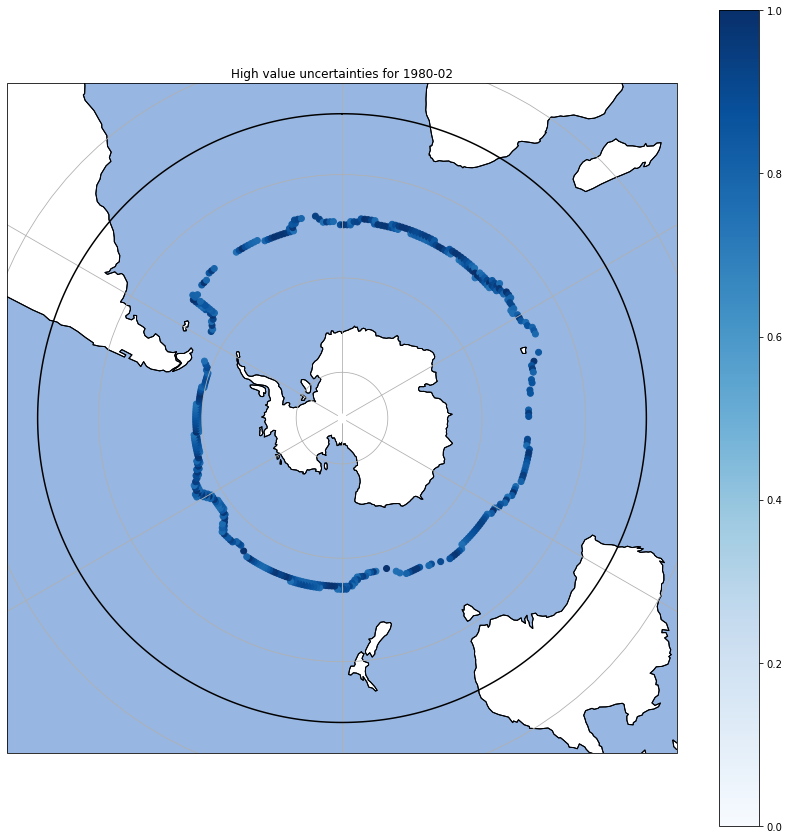

Single Month data identified and plotted and stored in monthlyData. 423 high classification uncertainty points identified.


In [27]:
testTime = "1980-02"
uncertaintyDFL = sampleMetaDFL[sampleMetaDFL["classUncertainty"] > 0.75]
monthlyData = uncertaintyDFL[uncertaintyDFL["time"]=="1980-02"]#["lon"].unique()
locationPlotUncertaintyDF(monthlyData, "High value uncertainties for "+testTime, (15,15), 1)
plt.show()
print("Single Month data identified and plotted and stored in monthlyData. "+str(len(monthlyData))+" high classification uncertainty points identified.")

<br>

### Mean Singular Latitudes over time

In [28]:
thresholds = [0.25, 0.50, 0.75, 0.85]
smoothFactor1 = 24
smoothFactor2 = 120
monthlyLatMMList = []
monthlyLatMMS1List = []
monthlyLatMMS2List = []

for i in range(len(thresholds)):
    uncertaintyDFL = sampleMetaDFL[sampleMetaDFL["classUncertainty"] > thresholds[i]]
    
    uncertaintyDFLLonTimeG = uncertaintyDFL.groupby(["lon","time"])
    uncertaintyDFLLonM = uncertaintyDFLLonTimeG.mean("lon")
    uncertaintyDFLLonM = uncertaintyDFLLonM.reorder_levels(['time', 'lon']).sort_index()
    uncertaintyDFLLonMTimeG = uncertaintyDFLLonM.groupby("time")
    
    monthlyLatMMList.append(uncertaintyDFLLonMTimeG.mean()[["lat"]])
    monthlyLatMMS1List.append(butter_lowpass(monthlyLatMMList[i]["lat"], smoothFactor1))
    monthlyLatMMS2List.append(butter_lowpass(monthlyLatMMList[i]["lat"], smoothFactor2))
print("Monthly Singular Mean Latitudes calculated, with smoothing.")

Monthly Singular Mean Latitudes calculated, with smoothing.


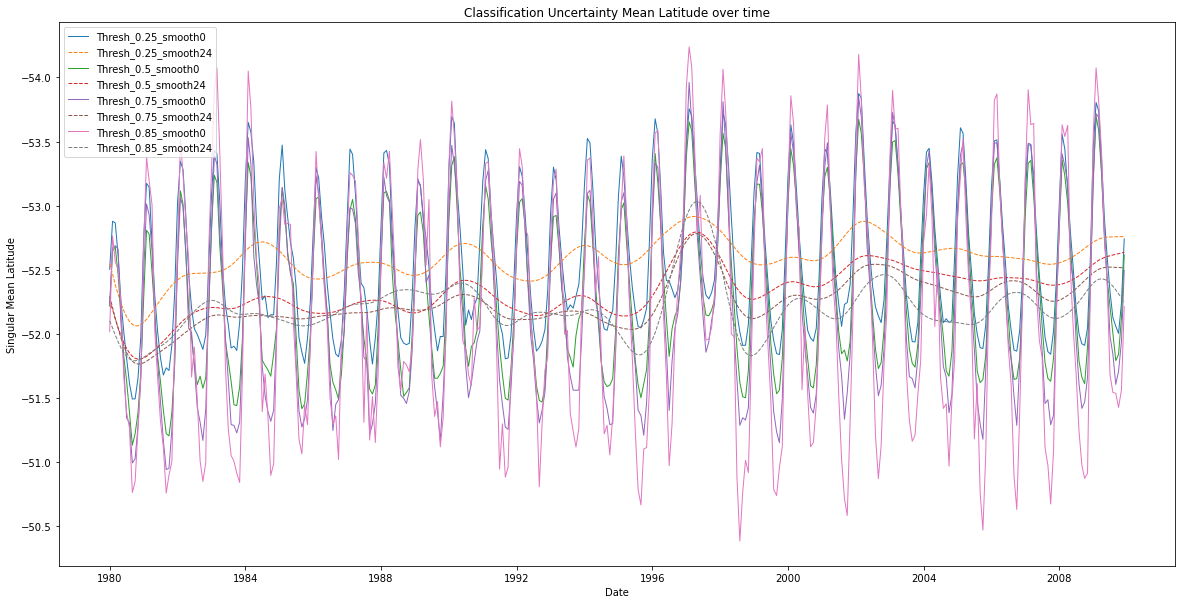

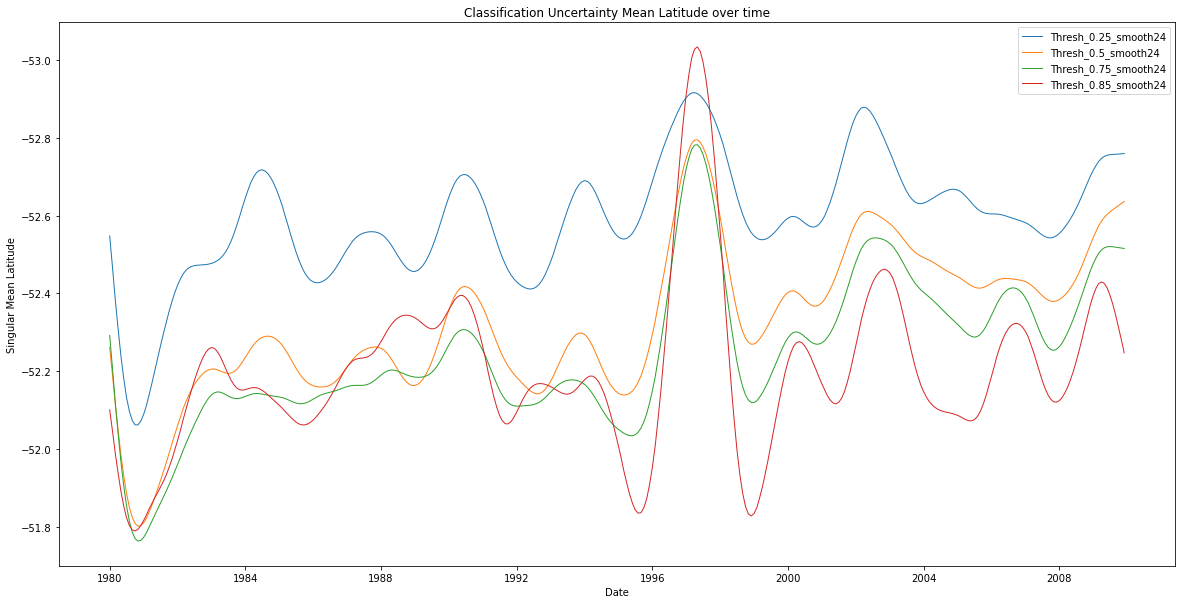

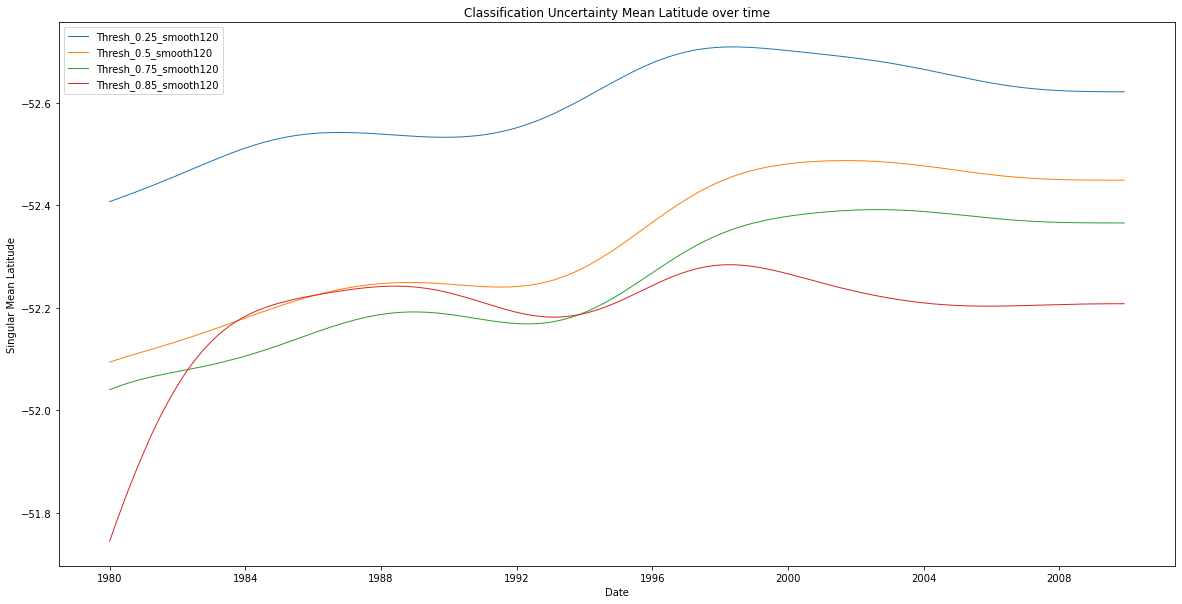

In [29]:
for i in range(len(thresholds)):
    timeSingleLatMean(monthlyLatMMList[i], "-", thresholds[i], 0, 1)
    timeSingleLatMean(monthlyLatMMS1List[i], "--", thresholds[i], smoothFactor1, 1)
    
    timeSingleLatMean(monthlyLatMMS1List[i], "-", thresholds[i], smoothFactor1, 2)
    timeSingleLatMean(monthlyLatMMS2List[i], "-", thresholds[i], smoothFactor2, 3)
    
for i in range(1, 4):    
    plt.figure(i)
    plt.gca().invert_yaxis()

plt.show()

<br>

### 1997 Dip investigation

Single Lat mean value for 1994 to 1998


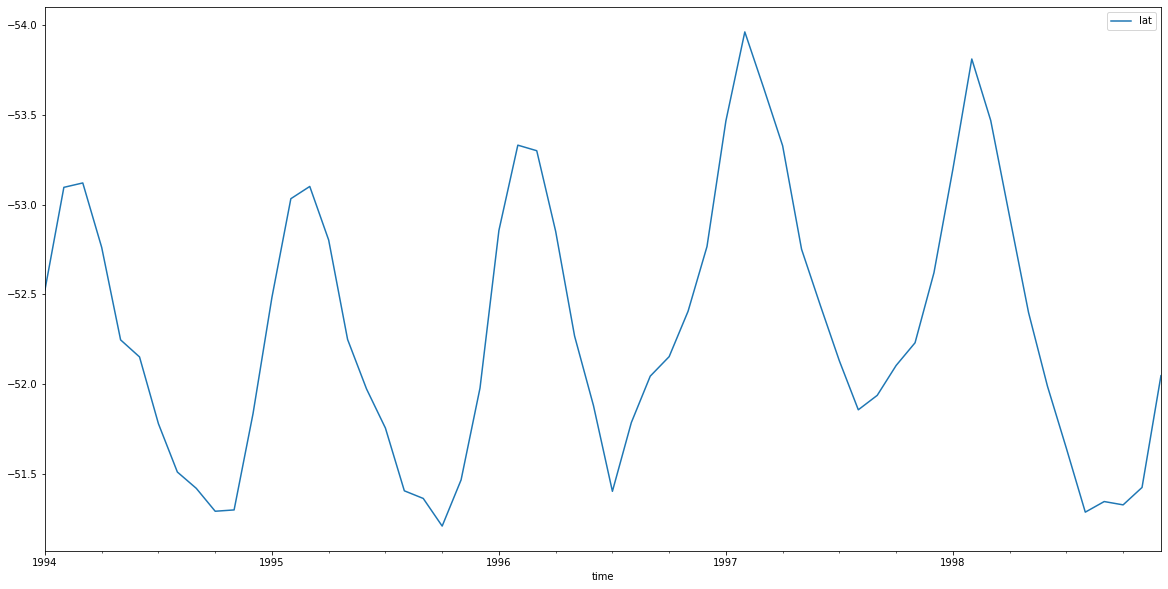

In [30]:
timeRange = np.arange(np.datetime64("1994-01",'M'), np.datetime64("1999-01", 'M'), np.timedelta64(1, 'M'))
breakDown = monthlyLatMMList[2]
timeRangeDF = breakDown[breakDown.index.isin(timeRange)]
timeRangeDF.plot(figsize=(20,10))
print("Single Lat mean value for 1994 to 1998")
plt.gca().invert_yaxis()
plt.show()

In [31]:
timeRangeClose = np.arange(np.datetime64("1996-01",'M'), np.datetime64("1998-01", 'M'), np.timedelta64(1, 'M'))
timeRangeCloseDF = sampleMetaDFL[sampleMetaDFL["time"].isin(timeRangeClose)]
avgGeoTimeRangeCloseDFG = timeRangeCloseDF.groupby(["lat", "lon"])
avgGeoTimeRangeCloseDF = avgGeoTimeRangeCloseDFG.mean(["lat", "lon"])
avgGeoTimeRangeCloseDF = avgGeoTimeRangeCloseDF.reset_index()
print("Average classification information calculated for 1996 - 1997, stored in avgGeoTimeRangeCloseDF.")

Average classification information calculated for 1996 - 1997, stored in avgGeoTimeRangeCloseDF.


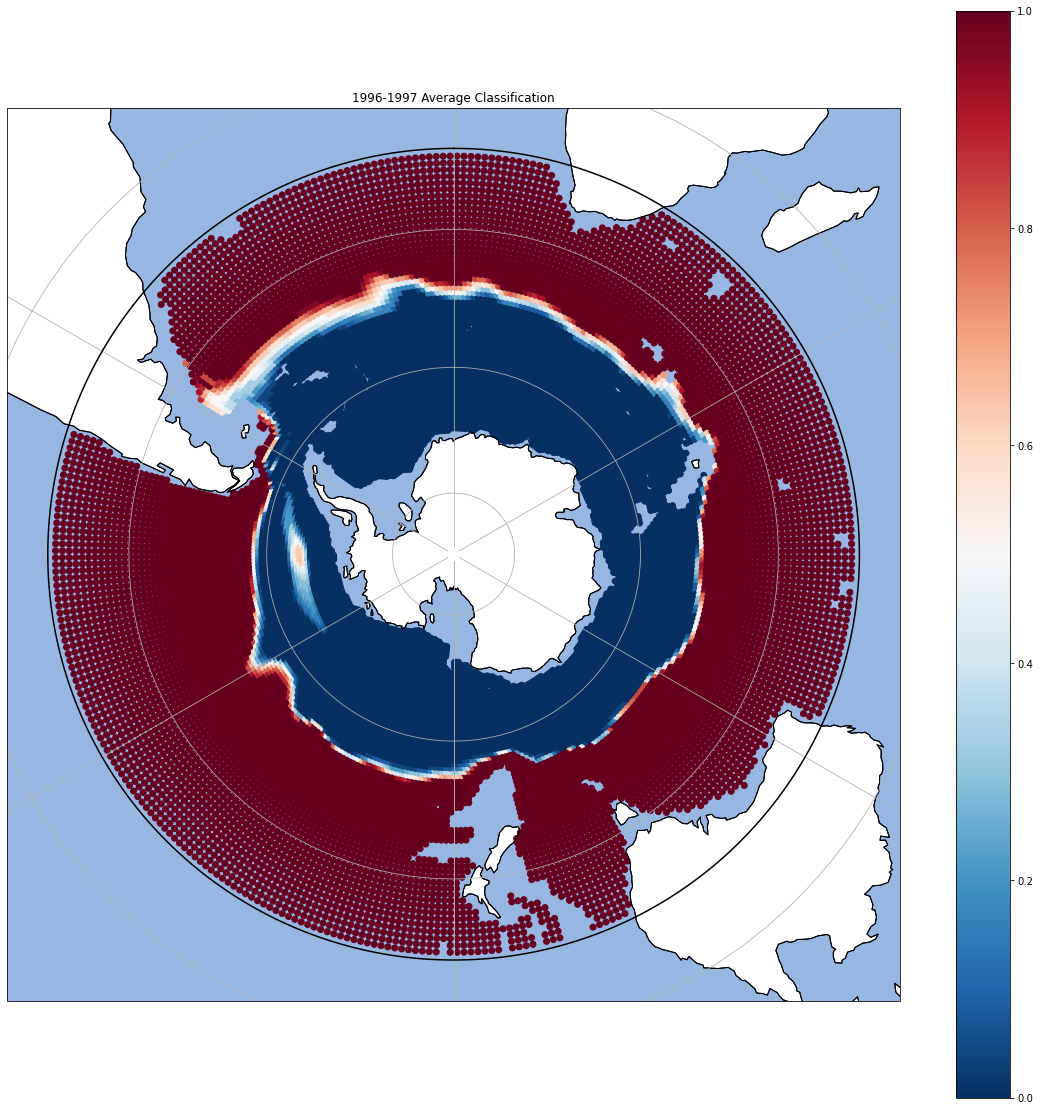

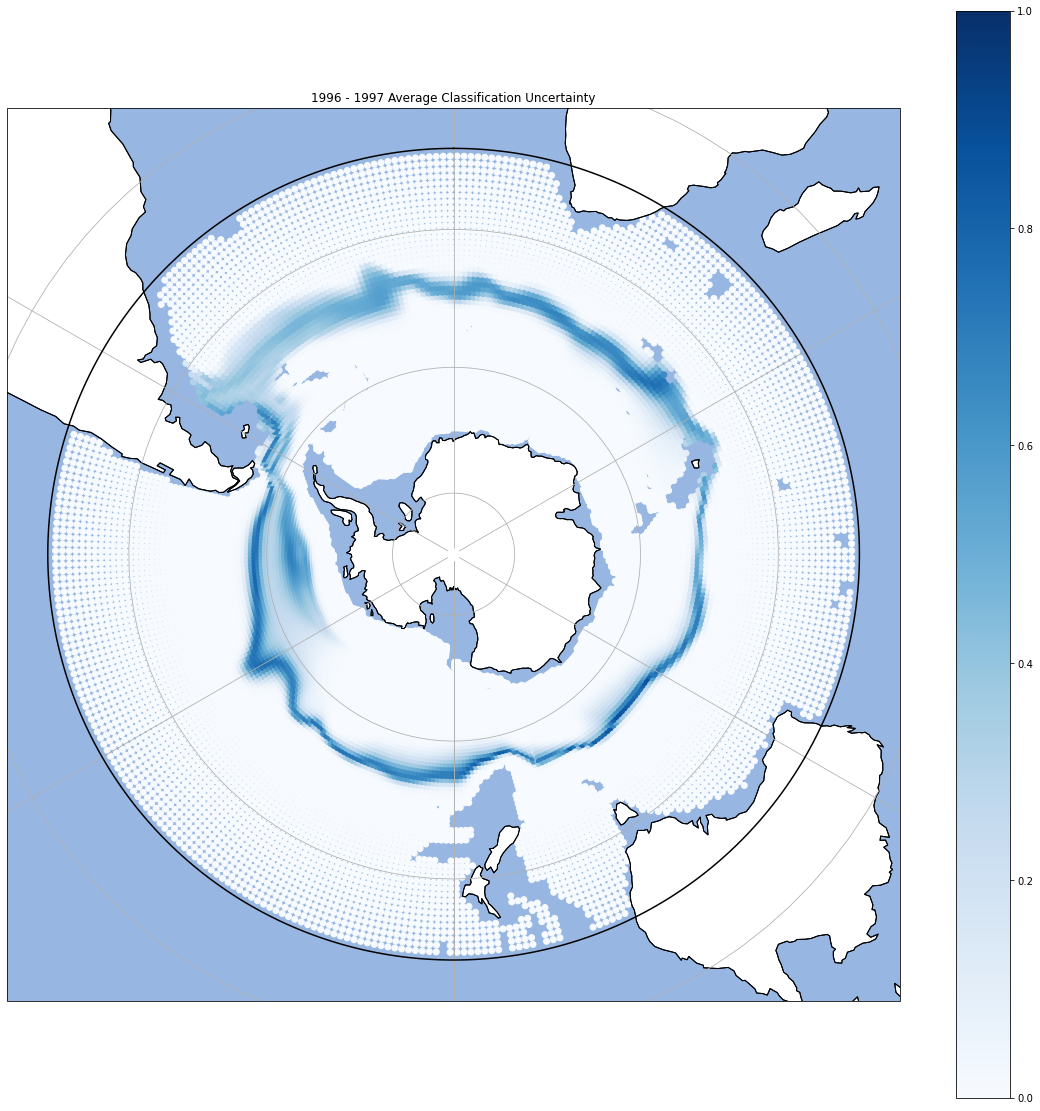

In [32]:
locationPlotGroupDFLab(avgGeoTimeRangeCloseDF, "1996-1997 Average Classification", (20,20), 1) #timeRangeCloseDF
locationPlotUncertaintyDF(avgGeoTimeRangeCloseDF, "1996 - 1997 Average Classification Uncertainty", (20,20), 2)
plt.show()

<br>

### Decadal investigation

In [33]:
decades = ["1980", "1990", "2000"]
decade80 = np.arange(np.datetime64("1980", 'M'), np.datetime64("1990", 'M'), np.timedelta64(1, 'M'))
decade90 = np.arange(np.datetime64("1990", 'M'), np.datetime64("2000", 'M'), np.timedelta64(1, 'M'))
decade00 = np.arange(np.datetime64("2000", 'M'), np.datetime64("2010", 'M'), np.timedelta64(1, 'M'))
decadeList = [decade80, decade90, decade00]
print("Decade lists created and stored in decade80, decade90 and decade00.")

Decade lists created and stored in decade80, decade90 and decade00.


In [34]:
sampleMetaDFDecList = [sampleMetaDFL[sampleMetaDFL["time"].isin(decade80)], sampleMetaDFL[sampleMetaDFL["time"].isin(decade90)], sampleMetaDFL[sampleMetaDFL["time"].isin(decade00)]]
print("Decade split performed and stored in sampleMetaDFDecList.")

Decade split performed and stored in sampleMetaDFDecList.


In [35]:
decDFIThreshList = []
decDFIThreshLatMList = []
decDFIThreshLatSList = []
threshold = 0.75

for i in range(len(decades)):
    decDF = sampleMetaDFDecList[i]
    decDFIThresh = decDF[decDF["classUncertainty"] > threshold]
    decDFIThreshList.append(decDFIThresh)
    
    decDFIThreshLonG = decDFIThresh.groupby("lon")
    decDFIThreshLatMList.append(decDFIThreshLonG.mean()[["lat"]])
    decDFIThreshLatSList.append(decDFIThreshLonG.std()[["lat"]])
print("Decadal class uncertainty latitude means calculted and stored in decDFIThreshLatMList. Standard deviations are stored in decDFIThreshLatSList.")

Decadal class uncertainty latitude means calculted and stored in decDFIThreshLatMList. Standard deviations are stored in decDFIThreshLatSList.


In [36]:
decDFIThreshLatMMList = []
for i in range(len(decDFIThreshLatMList)):
    decDFIThreshLatMMList.append(decDFIThreshLatMList[i]["lat"].mean())
    print("For "+str(decades[i])+" the singular mean latitude for a threshold of "+str(threshold)+" was "+str(np.round(decDFIThreshLatMMList[i], 2))+".")
print("Decade singular mean latitude values calculated.")

For 1980 the singular mean latitude for a threshold of 0.75 was -53.39.
For 1990 the singular mean latitude for a threshold of 0.75 was -52.4.
For 2000 the singular mean latitude for a threshold of 0.75 was -52.33.
Decade singular mean latitude values calculated.


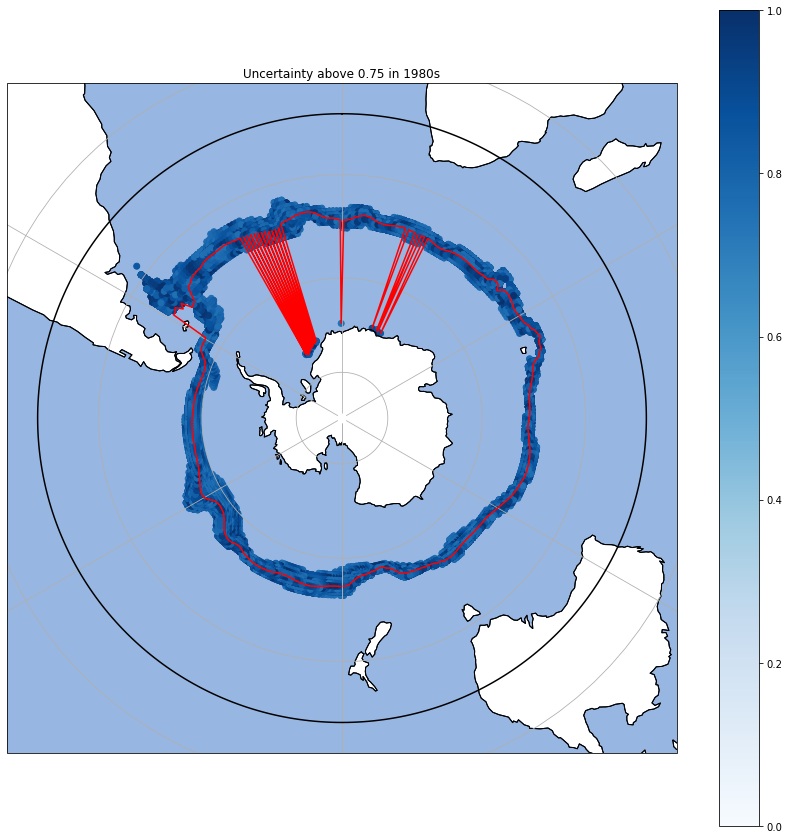

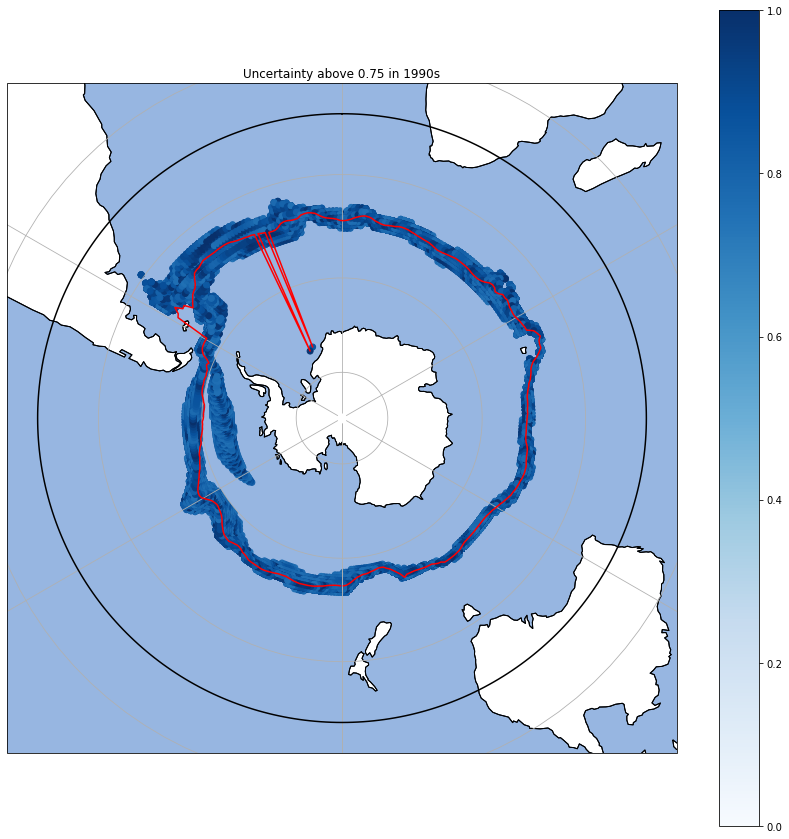

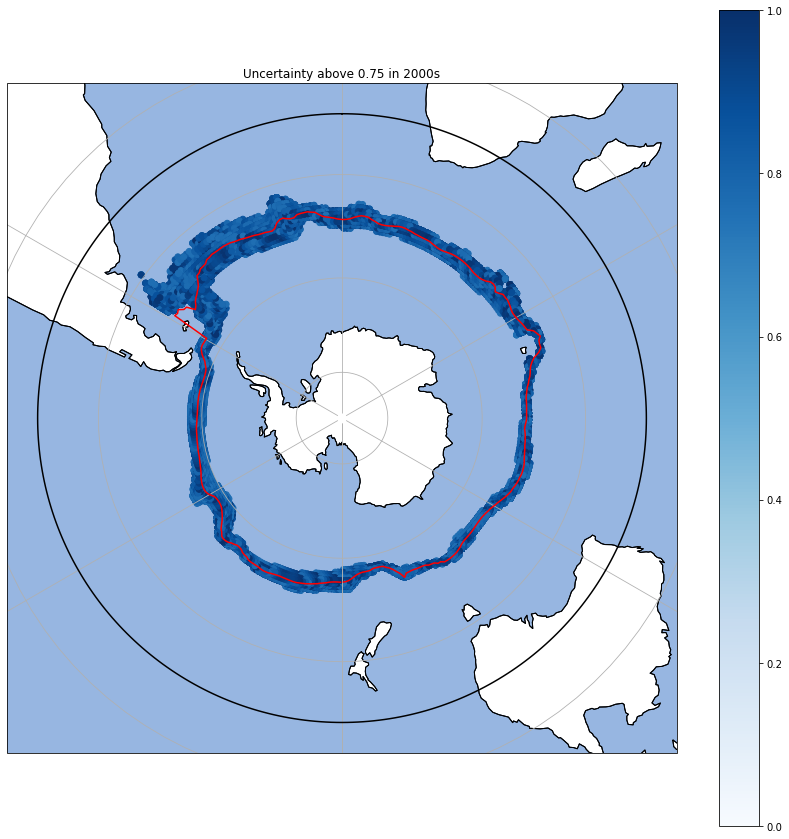

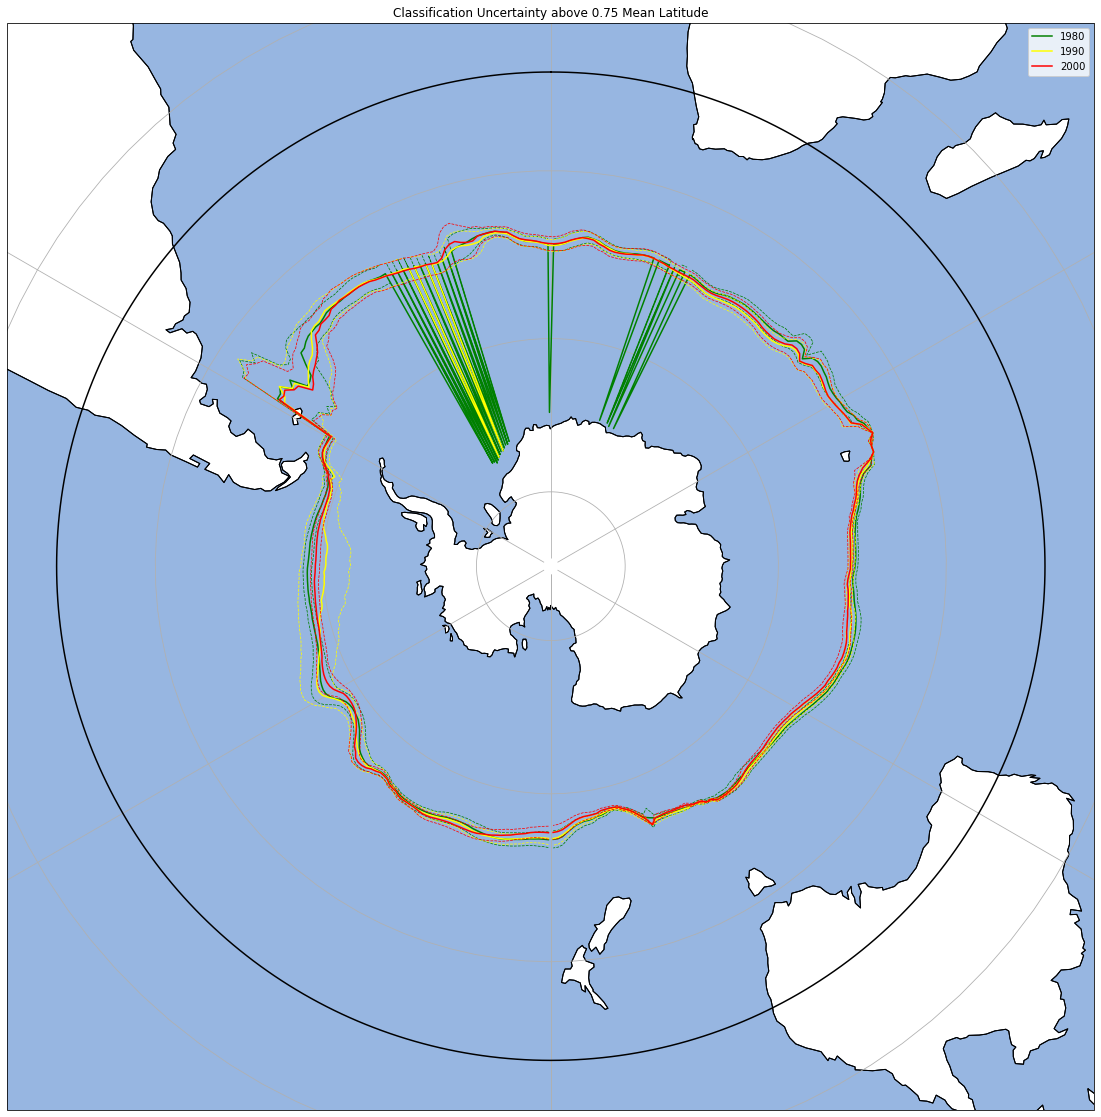

In [37]:
for i in range(len(decades)):    
    locationPlotUncertaintyDF(decDFIThreshList[i], "Uncertainty above "+str(threshold)+" in "+decades[i]+"s", (15,15), i)
    plt.plot(decDFIThreshLatMList[i].index, decDFIThreshLatMList[i]["lat"], transform=ccrs.PlateCarree(), color="red")
    
locationUncertaintyMean(decDFIThreshLatMList, decDFIThreshLatSList, threshold, (20,20), 4)
plt.show()

### Mean Investigation 

In [38]:
uncertaintyDFL = sampleMetaDFL[sampleMetaDFL["classUncertainty"] > 0.75]
uncertaintyDFLLonTimeG = uncertaintyDFL.groupby(["lon","time"])
uncertaintyDFLLonM = uncertaintyDFLLonTimeG.mean("lon")
uncertaintyDFLLonM = uncertaintyDFLLonM.reorder_levels(['time', 'lon']).sort_index()
print("uncertaintyDFLLonM")
uncertaintyDFLLonM

uncertaintyDFLLonM


lat  labelSorted  max posterior prob  \
time       lon                                                  
1980-01-01 -179.5 -53.757950          0.0            0.501180   
           -178.5 -54.051472          0.5            0.576419   
           -177.5 -54.051472          0.5            0.580319   
           -176.5 -54.051472          0.5            0.583820   
           -175.5 -54.051472          0.5            0.587008   
...                      ...          ...                 ...   
2009-12-01  175.5 -56.056770          1.0            0.533338   
            176.5 -55.775559          0.5            0.573201   
            177.5 -55.775559          0.5            0.561408   
            178.5 -55.494347          0.0            0.527472   
            179.5 -55.209061          0.5            0.578434   

                   classUncertainty  
time       lon                       
1980-01-01 -179.5          0.997639  
           -178.5          0.847163  
           -177.5          0.839361  
           -176.5          0.832360  
           -175.5          0.825984  
...                             ...  
2009-12-01  175.5          0.933324  
            176.5          0.853598  
            177.5          0.877184  
            178.5          0.945056  
            179.5          0.843133  

[102848 rows x 4 columns]

In [39]:
uncertaintyDFLLonMTimeG = uncertaintyDFLLonM.groupby("time")
monthlyLatMM = uncertaintyDFLLonMTimeG.mean()[["lat"]]
print("monthlyLatMM")
monthlyLatMM

monthlyLatMM


lat
time                 
1980-01-01 -52.232611
1980-02-01 -52.670652
1980-03-01 -52.688637
1980-04-01 -52.660078
1980-05-01 -52.089930
...               ...
2009-08-01 -51.839514
2009-09-01 -51.606199
2009-10-01 -51.709192
2009-11-01 -51.935906
2009-12-01 -52.495266

[360 rows x 1 columns]

In [40]:
z = monthlyLatMM[monthlyLatMM.index.isin(decade80)]
print("1980s monthly Means")
print("Total period mean: "+str(z.mean()["lat"]))
z

1980s monthly Means
Total period mean: -52.08357511192646


lat
time                 
1980-01-01 -52.232611
1980-02-01 -52.670652
1980-03-01 -52.688637
1980-04-01 -52.660078
1980-05-01 -52.089930
...               ...
1989-08-01 -51.586368
1989-09-01 -51.390016
1989-10-01 -51.168501
1989-11-01 -51.533833
1989-12-01 -52.010989

[120 rows x 1 columns]

### End of Notebook